In [1]:
# Diode I-V extraction demo
# This notebook generates diode I-V data, uses a least squares algorithm to find fitted parameters, and then visualizes the fit and the errors.

In [3]:
import numpy as np
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.models import DiodeModel
from src.extraction import ModelExtractor
from src.visualization import plot_fit, error_plot

In [4]:
model = DiodeModel()
extractor = ModelExtractor(model)

true_params = {"I_s": 1e-10, "n": 1.5}
V_data = np.linspace(0, 0.8, 200)
I_data_true = model.compute_current(V_data, true_params)

I_data = I_data_true * 1.05

In [5]:
initial_guess = {"I_s": 1e-6, "n": 1.67}
ls = extractor.diode_fit(V_data, I_data, initial_params=initial_guess)

ls

{'parameters': {'I_s': np.float64(1.0500000000000102e-10),
  'n': np.float64(1.500000000000001)},
 'rms_err': np.float64(5.318111000487643e-15),
 'max_err': np.float64(1.1570033369739572e-14),
 'success': True,
 'num_iters': 19,
 'message': '`gtol` termination condition is satisfied.'}

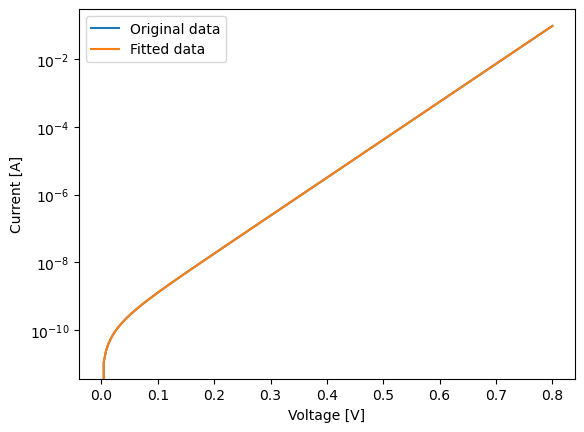

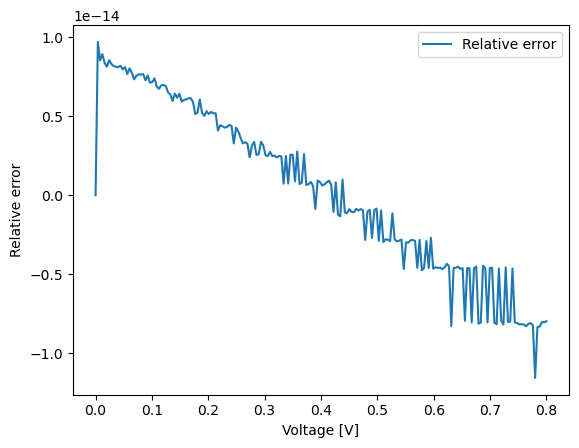

In [6]:
plot_fit(V_data, I_data, model, ls['parameters'])
error_plot(V_data, I_data, model, ls['parameters'])